In [1]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image    
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.models.components import feature_extractors

from anomalib.models.components.feature_extractors import TorchFXFeatureExtractor
from torchvision.models.densenet import DenseNet201_Weights
import torch.nn.functional as F
from anomalib.models.components.cluster.kmeans import KMeans
import torchvision.models as models

/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)


dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/yolov5results
  task: classification # options: [classification, segmentation]
  category: cat0/crops/od
  number_of_samples: 17999
  pre_selection: False
  train_batch_size: 1000
  eval_batch_size: 1000
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop:   # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.1 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.1 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_s

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [3]:

data_module = get_datamodule(config=config)
data_module.prepare_data() # check if the dataset is avaliable
data_module.setup()



In [4]:

feature_extractor = TorchFXFeatureExtractor(
                    backbone="densenet201",
                    return_nodes=["features.denseblock1.denselayer6.conv2"],
                    weights=DenseNet201_Weights.IMAGENET1K_V1,
                )


/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [5]:
# extract features from the whol training dataset

feature_list = []

for  i, train_data in enumerate(data_module.train_dataloader()):
    features = feature_extractor(train_data["image"])["features.denseblock1.denselayer6.conv2"]
    feature_list.append(features)



In [6]:
# convert the list of features to a tensor
global_feature_tensor = torch.vstack(feature_list)   

In [7]:
# global feature shape is (train_data size, channel, height, width)
print(global_feature_tensor.shape)

torch.Size([15658, 32, 64, 64])


In [8]:
from anomalib.models.components.cluster.kmeans import KMeans

def get_kmeans_centers(feature_tensor, n_clusters):
    """
    Args:
        feature_t: feature tensor, shape is (batch_size, channel, height, width)
        n_clusters: number of clusters
        
    Returns:
        cluster_center: shape is (n_clusters, channel)
        kmeans: kmeans model   """
    
    feature_t = feature_tensor.permute(1,0,2,3)
    feature_t = feature_t.flatten(start_dim=1)
    feature_t= feature_t.permute(1,0)


    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(feature_t)
    cluster_center = kmeans.cluster_centers_
   
    return cluster_center, kmeans



In [4]:
global_bow_stats_k2 = torch.load("/home/students/tyang/Documents/similiar_k2/global_bow_stats_k2top9.pt")
kmeans_k2 = torch.load("/home/students/tyang/Documents/similiar_k2/kmeans_category_0_k2top9.pt")

In [10]:
def bag_of_words_statistics(Ptst, Cref, S):
    """
    Params:
    Ptst: Feature tensor of a set of images, tensor of shape (N, C, H, W)
    Cref: reference Cluster centers, tensor of shape (K, C)
    S: number of subregions per image dimension, integer

    Returns:
    bow_stats: list of normalized Bag-of-words statistics, possibility-like , length N, each element is a tensor of shape (S * S, K)
    """
    Ptst = torch.vsplit(Ptst, Ptst.shape[0])
    bow_stats = []
    for Itst in Ptst:
        Itst = Itst.squeeze(0)
        #print(Itst.shape)
        subtensors = torch.chunk(Itst, S, dim=1)
        subtensor = [torch.chunk(st, S, dim=2) for st in subtensors]
        
        
        image_bow_stats = torch.zeros(S * S, len(Cref), dtype=torch.float32)
        for i in range(S):
            for j in range(S):
                st_value = subtensor[i][j]
                st_value = st_value.flatten(start_dim=1)
                st_value = st_value.permute(1,0)
               # print(st_value.shape)
                
                cluster_idx = kmeans.predict(st_value)
                #print(cluster_idx.shape)
                cluster_idx = cluster_idx.float()

                hist = torch.histc(cluster_idx, bins = len(Cref), min = torch.min(cluster_idx), max = torch.max(cluster_idx))
                normalized_hist = hist / torch.sum(hist)
                image_bow_stats[i * S + j] = normalized_hist
        
        bow_stats.append(image_bow_stats)
            
        
    return bow_stats


In [5]:
def kl_divergence(p, q):
   
    p = torch.clamp(p, min=1e-8)
    q = torch.clamp(q, min=1e-8)
    return (p * torch.log(p / q)).sum(dim=-1)

In [6]:
from sklearn_extra.cluster import KMedoids



def kl_distance(bow_stats,  step_size, nr_clusters):
    """
    Params:
    bow_stats: list of normalized Bag-of-words statistics, possibility-like , length N, each element is a tensor of shape (S * S, K)
    
    step_size: batch size,  integer

    Returns:
    selected_idx: list of selected image indices with highest kl-divergence in each batch, length number of batches, each element has the size of batch_size * select_ratio
    """
    
    stacked_bow_stats = torch.stack(bow_stats)
   # print(stacked_bow_stats.shape)
    
    kl_results = []
    for i in range(16):
        id_probs = stacked_bow_stats[:, i, :]

        p = id_probs.unsqueeze(1)  #  [N, 1, 5]
        q = id_probs.unsqueeze(0)  #  [1, N, 5]
    
        kl_div = kl_divergence(p, q)  #
        kl_div.fill_diagonal_(0)  

        kl_results.append(kl_div)

    kl_results_stacked = torch.stack(kl_results)
    kl_average = torch.mean(kl_results_stacked, dim=0)




    kmedoids = KMedoids(n_clusters=nr_clusters, metric='precomputed', method='alternate')
    kmedoids.fit(kl_average)
    medoids_indices = kmedoids.medoid_indices_

    selected_idx = [[] for _ in range(len(bow_stats) // step_size + 1)]

    for global_id in medoids_indices:
        batch_id = global_id // step_size
        local_id = global_id % step_size
        selected_idx[batch_id].append(local_id)
        


    return medoids_indices, kl_average, selected_idx
    
    

    
     
        

    
  

In [7]:
medoid_indices_k2, distance_mrx_k2, selected_idx_k2 = kl_distance(global_bow_stats_k2, 1000, 9)

torch.Size([15658, 16, 2])


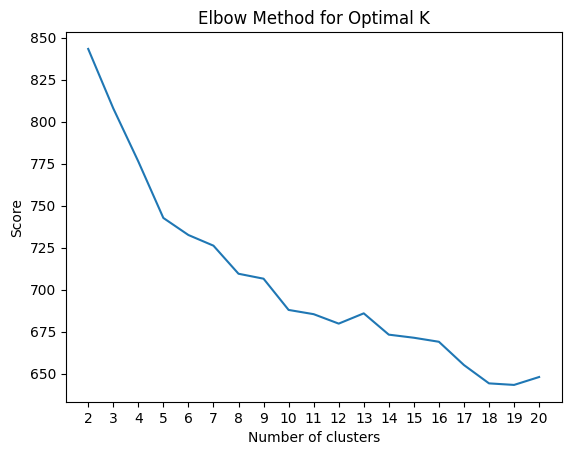

In [9]:
import numpy as np



def compute_kmedoids(sample_matrix, max_k):
    scores = []
    for k in range(2, max_k + 1):
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', method='alternate')
        kmedoids.fit(sample_matrix)
        scores.append(kmedoids.inertia_)  # Sum of distances of samples to their closest cluster center
    return scores

import matplotlib.pyplot as plt

max_k = 20  # set a reasonable upper limit
scores = compute_kmedoids( distance_mrx_k2, max_k)

plt.plot(range(2, max_k + 1), scores)
plt.xlabel('Number of clusters')
plt.xticks(range(2, max_k + 1))
plt.ylabel('Score')
plt.title('Elbow Method for Optimal K')
plt.show()


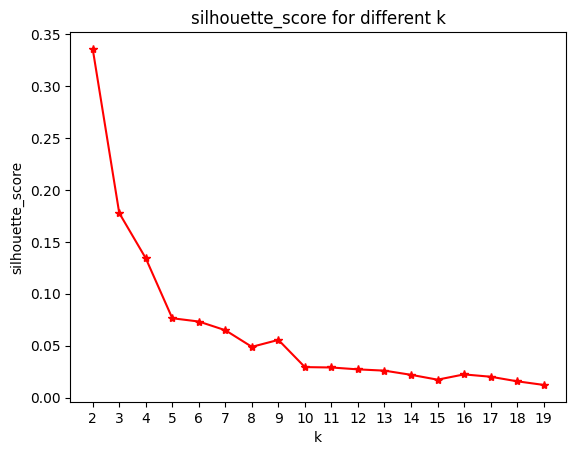

In [10]:
from sklearn.metrics import silhouette_score

k = range(2,20)
score = []
for i in k:
    kmedoids = KMedoids(n_clusters=i, metric='precomputed', method='alternate')
    kmedoids.fit(distance_mrx_k2)
    score.append(silhouette_score(distance_mrx_k2, kmedoids.labels_, metric='precomputed'))


plt.plot(k,score,'r*-')
plt.xlabel('k')
plt.xticks(k)
plt.ylabel(u'silhouette_score')
plt.title(u'silhouette_score for different k')
plt.show()

In [ ]:
torch.save(medoid_indices_k2, "/home/students/tyang/Documents/medoid_indices_k2_medoids9.pt")
merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][selected_idx], "label": train_data["label"][selected_idx]} for selected_idx in selected_idx_k2[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)


import csv 

csv_path = "/home/students/tyang/Documents/category0_k2_medoides9.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)   

In [30]:
medoid_indices, distance_mrx, selected_idxs = kl_distance(global_bow_stats_k2,  step_size=1000, nr_clusters=9)

In [31]:
print(medoid_indices)
print(selected_idxs)
#print(batch_indices)

[13204 14072  7765 13284  2579  1434 15378 10228  7502]
[[], [434], [579], [], [], [], [], [765, 502], [], [], [228], [], [], [204, 284], [72], [378]]


In [32]:
medoid_indices = torch.tensor(medoid_indices)
torch.save(medoid_indices, "/home/students/tyang/Documents/medoid_indices_k5_medoids9.pt")

In [34]:
merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][selected_idx], "label": train_data["label"][selected_idx]} for selected_idx in selected_idxs[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    



In [35]:
print(merged_datas["image_path"])

['/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001634.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN002950.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN008900.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN008602.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN011741.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN015148.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN015240.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN016165.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN017671.jpg']


In [36]:
print(len(merged_datas["image_path"]))

9


In [37]:
import csv 

csv_path = "/home/students/tyang/Documents/category0_k5_medoides9.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)